In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import itertools
from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/maxim_ryazanov/MADE/3Sem/rl/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import torchvision.datasets as datasets
from torchvision.utils import make_grid

# Pix2Pix

In [3]:
def show_image(tensor):
    plt.figure(figsize=(2,2))
    plt.imshow(tensor.permute(1, 2, 0))

In [4]:
image_size = 256
image_shape = (3, image_size, image_size)

cuda = True if torch.cuda.is_available() else False
print(f"Using cuda {cuda}")
cuda = False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

batch_size = 10

Using cuda True


In [5]:
ds = datasets.ImageFolder(
        "facades",
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    )
train_count = int(len(ds) * 0.7)
valid_count = 0
test_count = len(ds) - train_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    ds, (train_count, valid_count, test_count)
)
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
)

## Генератор
В качестве генератора используем Unet (как в статье)
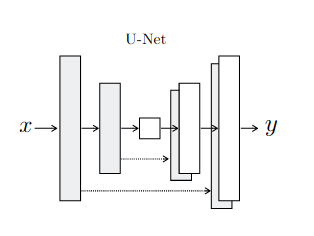

в которой выходы слоев кодировщика подмешиваются в выходы слоев декодировщика

In [6]:
class UnetGenerator(nn.Module):
    def __init__(self, d=64):
        super(UnetGenerator, self).__init__()
        
        self.conv1 = nn.Sequential( # 128 x 128
            nn.Conv2d(3, d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential( # 32 x 32
            nn.Conv2d(d, d * 2, 8, 4, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(d * 2),
        )
        self.conv3 = nn.Sequential( # 8 x 8
            nn.Conv2d(d * 2, d * 4, 8, 4, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(d * 4),
        )
        self.conv4 = nn.Sequential( # 7 x 7
            nn.Conv2d(d * 4, d * 8, 4, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(d * 8),
        )
        self.conv5 = nn.Sequential( # 1 x 1
            nn.Conv2d(d * 8, d * 8, 7, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(d * 8, d * 8, 7, 1, 0),
            nn.BatchNorm2d(d * 8),
            nn.Dropout2d(0.25),
        )
        
        self.deconv2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 1, 1),
            nn.BatchNorm2d(d * 4),
            nn.Dropout2d(0.25),
        )
        
        self.deconv3 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 4 * 2, d * 2, 8, 4, 2),
            nn.BatchNorm2d(d * 2),
            nn.Dropout2d(0.25),
        )
        
        self.deconv4 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 2 * 2, d, 8, 4, 2),
            nn.BatchNorm2d(d ),
            nn.Dropout2d(0.25),
        )
        
        self.deconv5 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 2, 3, 4, 2, 1),
            nn.Tanh(),
        )
            
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        
        d1 = self.deconv1(e5)
        d1 = torch.cat([d1, e4], 1)
        d2 = self.deconv2(d1)
        d2 = torch.cat([d2, e3], 1)
        d3 = self.deconv3(d2)
        d3 = torch.cat([d3, e2], 1)
        d4 = self.deconv4(d3)
        d4 = torch.cat([d4, e1], 1)
        d5 = self.deconv5(d4)
        return d5


In [ ]:
g = UnetGenerator()
show_image(g(ds[128][0][:,:,:256].unsqueeze(0)).squeeze().detach())

### Дискриминатор

In [57]:
class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(6, d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d, d * 2, 4, 2, 1),
            nn.BatchNorm2d(d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d * 2, d * 4, 4, 2, 1),
            nn.BatchNorm2d(d * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d * 4, d * 8, 4, 1, 1),
            nn.BatchNorm2d(d * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d * 8, 1, 4, 1, 1),
        )
        self.linear = nn.Sequential(
            nn.Linear(900, 1),
            #nn.Sigmoid(),
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)

        return x

### Pix2Pix

In [60]:
class Pix2Pix:
    def __init__(self, generator, discriminator, loss, data, lam=1, cuda=False):
        self.generator = generator
        self.discriminator = discriminator
        self.data = data
        self.loss = loss
        self.lam = lam
        self.l1_loss = torch.nn.L1Loss()
        
        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.loss.cuda()
            self.l1_loss.cuda()
        
        ## Оптимизаторы и их параметры
        lr, beta1, beta2 = 0.0002, 0.5, 0.999
        self.opt_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, beta2))
        self.opt_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    
    def do_epoch(self, imgs, i):
        # целевые переменные (0-1) для настоящих и фейковых картинок
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        
        self.opt_G.zero_grad()
        y, x = Variable(imgs[:,:,:,:256].type(Tensor)), Variable(imgs[:,:,:,256:].type(Tensor))
        
        gen_imgs = self.generator(x)

        
        d_res = self.discriminator(x, gen_imgs)
        g_loss = self.loss(d_res, valid) + self.lam * self.l1_loss(gen_imgs, y)

        g_loss.backward()
        self.opt_G.step()
        
        self.opt_D.zero_grad()
        
        real_loss = self.loss(self.discriminator(x, y), valid)
        fake_loss = self.loss(self.discriminator(x, gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        self.opt_D.step()
        return gen_imgs, d_loss, g_loss

    def fit(self, num_epochs, every, healthcheck):
        d_losses, g_losses = [], []
        for epoch in range(num_epochs):
            for i, (imgs, _) in enumerate(self.data):
                gen_imgs, d_loss, g_loss = self.do_epoch(imgs, i)
                if d_loss is not None and g_loss is not None:
                    d_losses.append(d_loss.item())
                    g_losses.append(g_loss.item())
                batches_done = epoch * len(dataloader) + i
                if batches_done % healthcheck == 0:
                    print(f'Epoch {epoch}, batch {batches_done}')
                if batches_done % every == 0:
                    print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(dataloader), d_losses[-1], g_losses[-1]))
                    #show_image(gen_imgs.data[0])
                    save_image(gen_imgs.data[:5], "%s/%05d.png" % ('data', batches_done), nrow=5, normalize=True)
        return d_losses, g_losses
    
    def transform(self, image):
        with torch.no_grad():
            return self.generator(image)

In [58]:
generator = UnetGenerator()
discriminator = Discriminator()
#loss = torch.nn.BCELoss()
loss = torch.nn.MSELoss()
p2p = Pix2Pix(generator, discriminator, loss, dataloader, cuda=False)

In [59]:
p2p.fit(100, 10, 5)

Epoch 0, batch 0
	...epoch 0/100	batch 0/43	D loss: 0.628847	G loss: 7.100135
Epoch 0, batch 5
Epoch 0, batch 10
	...epoch 0/100	batch 10/43	D loss: 0.529707	G loss: 3.442312
Epoch 0, batch 15
Epoch 0, batch 20
	...epoch 0/100	batch 20/43	D loss: 0.503074	G loss: 1.686684
Epoch 0, batch 25
Epoch 0, batch 30
	...epoch 0/100	batch 30/43	D loss: 0.319286	G loss: 11.500943
Epoch 0, batch 35
Epoch 0, batch 40
	...epoch 0/100	batch 40/43	D loss: 0.178530	G loss: 6.334821
Epoch 1, batch 45
Epoch 1, batch 50
	...epoch 1/100	batch 7/43	D loss: 0.432444	G loss: 11.218411
Epoch 1, batch 55
Epoch 1, batch 60
	...epoch 1/100	batch 17/43	D loss: 0.210259	G loss: 2.302670
Epoch 1, batch 65
Epoch 1, batch 70
	...epoch 1/100	batch 27/43	D loss: 0.288951	G loss: 3.599205
Epoch 1, batch 75
Epoch 1, batch 80
	...epoch 1/100	batch 37/43	D loss: 0.213378	G loss: 3.780044
Epoch 1, batch 85
Epoch 2, batch 90
	...epoch 2/100	batch 4/43	D loss: 0.210645	G loss: 2.691678
Epoch 2, batch 95
Epoch 2, batch 100
	...

KeyboardInterrupt: 

## Эволюция фасадов

![](assets/00000.png "Первая эпоха")
![](assets/01000.png "3050 батчей")
![](assets/02100.png)
![](assets/03500.png)
![](assets/04800.png)
![](assets/15600.png)
![](assets/24700.png)

Последний результат - 500 эпоха обучения. Модель достаточно быстро начинает давать похожий на дома результат, но с ростом эпохи прогресс становится менее заметным, модель начинает переобучаться на артефактах изображений.

### Демонстрация

In [10]:
p2p_generator_state_dict = torch.load('p2pgenerator.pt')

In [11]:
generator = UnetGenerator()
generator.load_state_dict(p2p_generator_state_dict)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


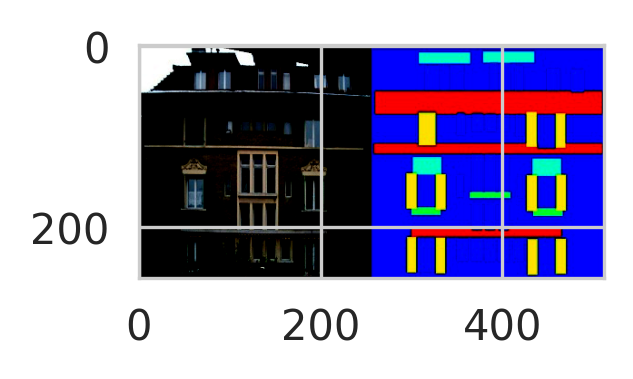

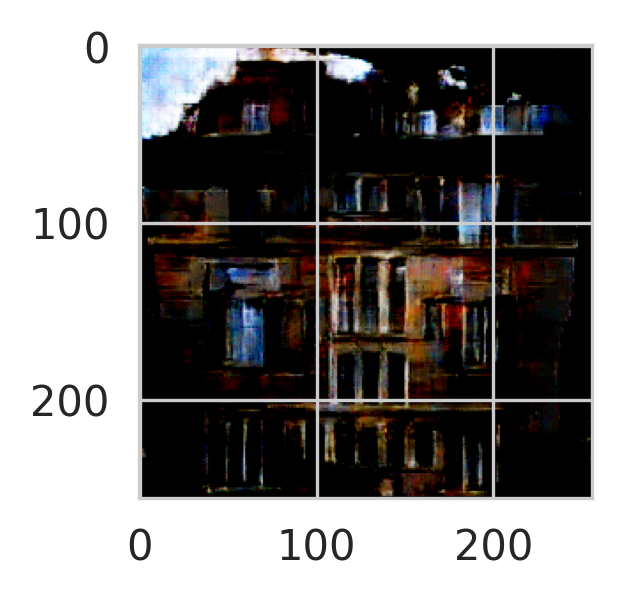

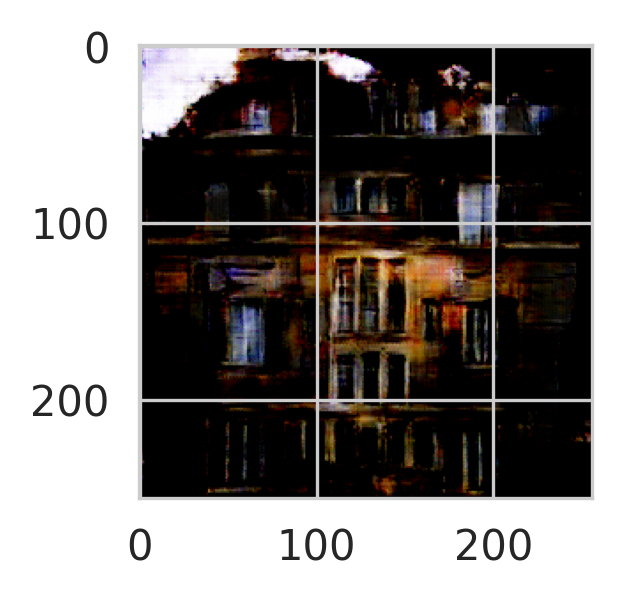

In [54]:
image = train_dataset[2][0]
show_image(image)
with torch.no_grad():
    show_image(generator(image[:,:, 256:].unsqueeze(0)).squeeze())
    show_image(generator(image[:,:, 256:].unsqueeze(0)).squeeze())
    #show_image(generator(image[:,:, :256].unsqueeze(0)).squeeze())

## CycleGan

In [7]:
# Тот же дискриминатор, что и раньше но принимает только одно изображение
class SingleDiscriminator(nn.Module):
    def __init__(self, d=64):
        super(SingleDiscriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d, d * 2, 4, 2, 1),
            nn.BatchNorm2d(d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d * 2, d * 4, 4, 2, 1),
            nn.BatchNorm2d(d * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d * 4, d * 8, 4, 1, 1),
            nn.BatchNorm2d(d * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(d * 8, 1, 4, 1, 1),
        )
        self.linear = nn.Sequential(
            nn.Linear(900, 1),
            #nn.Sigmoid(),
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)

        return x

In [8]:
class CycleGan:
    def __init__(self, loss, data, lam=10, cuda=False):
        self.F = UnetGenerator()
        self.Dx = SingleDiscriminator()
        self.G = UnetGenerator()
        self.Dy = SingleDiscriminator()
        self.data = data
        self.loss = loss
        self.lam = lam
        self.l1_loss = torch.nn.L1Loss()
        
        if cuda:
            self.F.cuda()
            self.G.cuda()
            self.Dx.cuda()
            self.Dy.cuda()
            self.loss.cuda()
            self.l1_loss.cuda()
        
        ## Оптимизаторы и их параметры
        lr, beta1, beta2 = 0.0002, 0.5, 0.999
        self.opt_G = torch.optim.Adam(itertools.chain(self.G.parameters(), self.F.parameters()), lr=lr, betas=(beta1, beta2))
        self.opt_D = torch.optim.Adam(itertools.chain(self.Dx.parameters(), self.Dy.parameters()), lr=lr, betas=(beta1, beta2))

    def do_epoch(self, imgs, i):
        # целевые переменные (0-1) для настоящих и фейковых картинок
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # обучаем генераторы
        self.opt_G.zero_grad()
        y, x = Variable(imgs[:,:,:,:256].type(Tensor)), Variable(imgs[:,:,:,256:].type(Tensor))
    
        # Генерируем циклы
        y_to = self.G(x)
        x_from = self.F(y_to)
        x_to = self.F(y)
        y_from = self.G(x_to)
        
        ccx_loss = self.l1_loss(x, x_from)
        ccy_loss = self.l1_loss(y, y_from)
        
        dx_res = self.Dx(x_to)
        dy_res = self.Dy(y_to)
        g_loss = self.loss(dx_res, valid) + self.loss(dy_res, valid) + ccx_loss + ccy_loss

        g_loss.backward()
        self.opt_G.step()
        self.opt_D.zero_grad()
        
        realx_loss = self.loss(self.Dx(x), valid)
        fakex_loss = self.loss(self.Dx(x_to.detach()), fake)
        dx_loss = (realx_loss + fakex_loss) / 2
        dx_loss.backward()
        
        realy_loss = self.loss(self.Dy(y), valid)
        fakey_loss = self.loss(self.Dy(y_to.detach()), fake)
        dy_loss = (realy_loss + fakey_loss) / 2
        dy_loss.backward()
        self.opt_D.step()
        return x, x_to, y_to, dx_loss, dy_loss, g_loss

    def fit(self, num_epochs, every, healthcheck):
        d_losses, g_losses = [], []
        for epoch in range(num_epochs):
            for i, (imgs, _) in enumerate(self.data):
                x, fake_x, fake_y, dx_loss, dy_loss, g_loss = self.do_epoch(imgs, i)
                if dy_loss is not None and g_loss is not None:
                    d_losses.append(dy_loss.item())
                    g_losses.append(g_loss.item())
                batches_done = epoch * len(dataloader) + i
                if batches_done % healthcheck == 0:
                    print(f'Epoch {epoch}, batch {batches_done}')
                if batches_done % every == 0:
                    print("\t...epoch %d/%d\tbatch %d/%d\tDx loss: %.6f\t Dy loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(dataloader), dx_loss, dy_loss, g_losses[-1]))
                    #show_image(gen_imgs.data[0])
                    save_image(fake_y[:5], "%s/%05dy.png" % ('data', batches_done), nrow=5, normalize=True)
                    save_image(fake_x[:5], "%s/%05dx.png" % ('data', batches_done), nrow=5, normalize=True)
        return d_losses, g_losses
    
    def transform(self, image):
        with torch.no_grad():
            return self.generator(image)

In [9]:
loss = nn.MSELoss()
cycle_gan = CycleGan(loss, dataloader)
#cycle_gan.fit(50, 5, 2)

Epoch 0, batch 0
	...epoch 0/50	batch 0/43	Dx loss: 0.706999	 Dy loss: 0.540337	G loss: 4.666335
Epoch 0, batch 2
Epoch 0, batch 4
	...epoch 0/50	batch 5/43	Dx loss: 0.732637	 Dy loss: 0.354377	G loss: 1.863413
Epoch 0, batch 6
Epoch 0, batch 8
Epoch 0, batch 10
	...epoch 0/50	batch 10/43	Dx loss: 0.828592	 Dy loss: 0.677332	G loss: 4.779912
Epoch 0, batch 12
Epoch 0, batch 14
	...epoch 0/50	batch 15/43	Dx loss: 0.139944	 Dy loss: 0.285671	G loss: 2.663724
Epoch 0, batch 16
Epoch 0, batch 18
Epoch 0, batch 20
	...epoch 0/50	batch 20/43	Dx loss: 0.973283	 Dy loss: 1.754462	G loss: 2.531279
Epoch 0, batch 22
Epoch 0, batch 24
	...epoch 0/50	batch 25/43	Dx loss: 0.139716	 Dy loss: 0.230276	G loss: 2.433403
Epoch 0, batch 26
Epoch 0, batch 28
Epoch 0, batch 30
	...epoch 0/50	batch 30/43	Dx loss: 0.326286	 Dy loss: 0.379835	G loss: 3.412373
Epoch 0, batch 32
Epoch 0, batch 34
	...epoch 0/50	batch 35/43	Dx loss: 0.167007	 Dy loss: 0.157328	G loss: 2.512008
Epoch 0, batch 36
Epoch 0, batch 38

KeyboardInterrupt: 

## Результаты cycle gan
![](assets/03800y.png)
![](assets/03800x.png)
![](assets/05200y.png)

К 100 эпохе начинают прорисовываться очертания зданий, определяется цвет. К сожалению, на дальнейшее обучение времени не хватило.

In [62]:
cgan_to_photo_state_dict = torch.load('to_photo.pt')
cgan_to_label_state_dict = torch.load('to_label.pt')

In [63]:
to_photo_gen = UnetGenerator()
to_photo_gen.load_state_dict(cgan_to_photo_state_dict)

to_label_gen = UnetGenerator()
to_label_gen.load_state_dict(cgan_to_label_state_dict)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


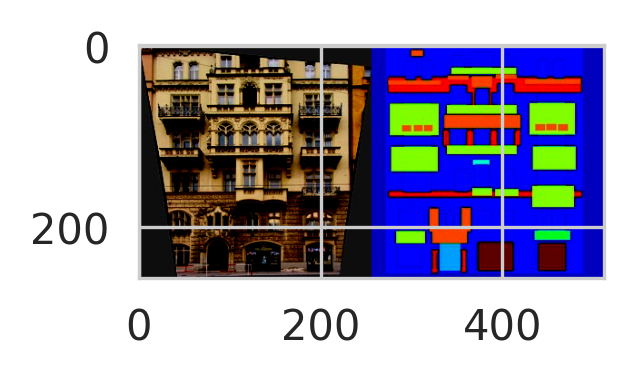

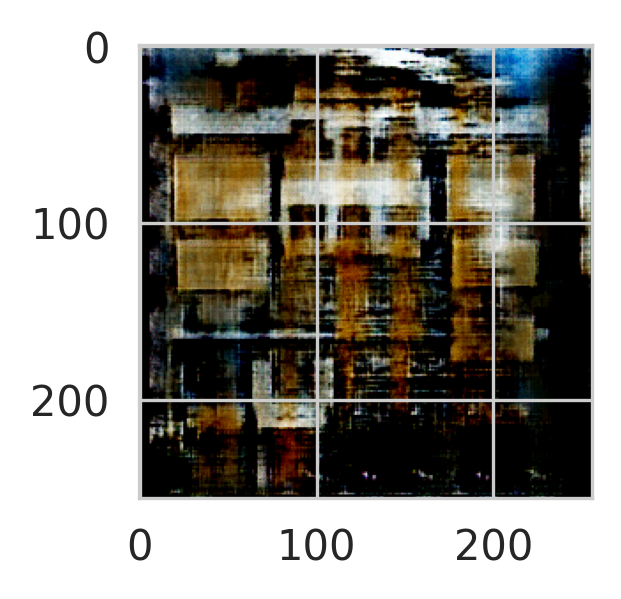

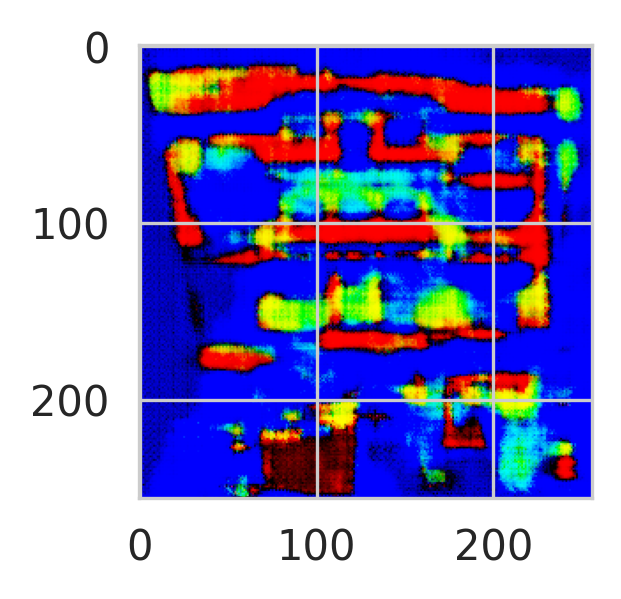

In [67]:
image = train_dataset[10][0]
show_image(image)
with torch.no_grad():
    show_image(to_photo_gen(image[:,:, 256:].unsqueeze(0)).squeeze())
    show_image(to_label_gen(image[:,:, :256].unsqueeze(0)).squeeze())
    #show_image(generator(image[:,:, :256].unsqueeze(0)).squeeze())